## Importing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

sell_data_train = pd.read_csv('train.csv', index_col='id')
sell_data_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [2]:
sell_data_train.shape

(381109, 11)

## Data exploration

In [3]:
# Missing values

sell_data_train.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [4]:
# Checking data types

sell_data_train.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

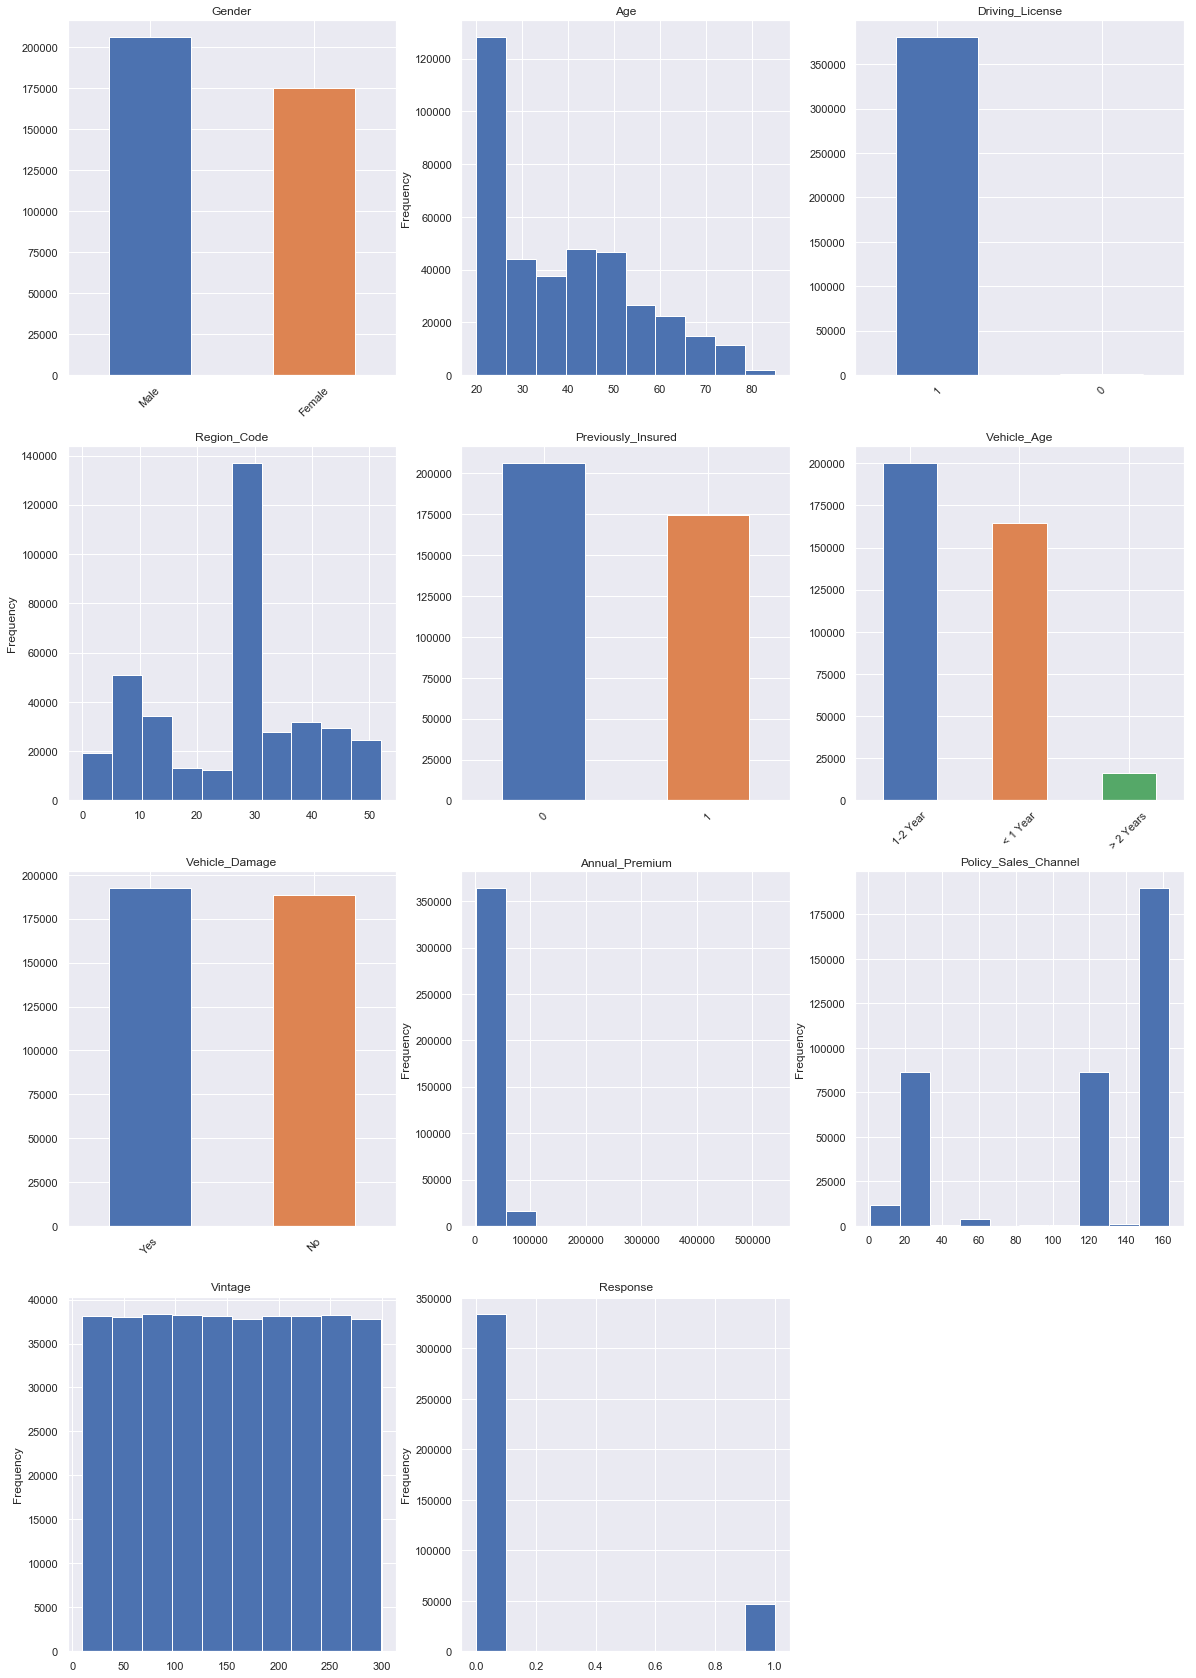

In [5]:
# Visualising distribution 

fig = plt.figure(figsize=(20,30))
axs = []

binary_col = [2,4]

for n in range(11):
    ax = fig.add_subplot(4, 3, n+1)
    col = sell_data_train.columns[n]
    if n in binary_col or sell_data_train[col].dtype == object:
        sell_data_train[col].value_counts(dropna=False).plot(
            kind='bar',
            ax=ax,
            title=sell_data_train.columns[n]
        )
        ax.tick_params(axis='x', rotation=45)
    else:
        sell_data_train[col].plot(kind='hist', ax=ax, title=sell_data_train.columns[n])

(0, 150000)

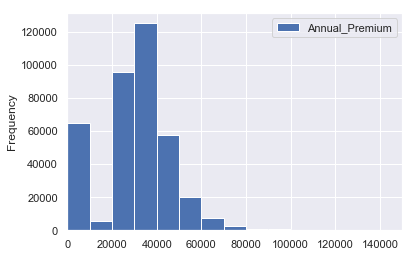

In [6]:
# Looking at 'Annual Premium' in more detail

ax = sell_data_train[['Annual_Premium']].plot(kind='hist', bins=[0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000])
ax.set_xlim(0,150000)

<b>Some observations / to-do </b><br>
- Need to <b>encode</b> 'Gender' (one-hot), 'Vehicle_Damage' (one-hot), 'Vehicle_Age' (ordinal)
- Need to <b>scale</b> 'Age', 'Region_Code, 'Policy_Sales_Channel', 'Vintage'
- 'Age', 'Region_Code', 'Policy_Sales_Channel' are <b>skewed</b>. Check dictionary for meaning of last two columns. Keep in mind for later.
- 'Driving_License' is '1' for all instances, so has no predictive value. Let's drop it. 
- There is significant <b>class imbalance in the target class</b>! The positive class (i.e. successful sale) is much less common, while being very important for us to predict. Will use imbalanced-learn library to implement oversampling using SMOTENC.

## Data preparation

In [7]:
# Setting y, X_train

y_train = np.array(sell_data_train[['Response']])
X_train = sell_data_train.drop('Response', axis=1)

# Defining column transformer to pass to pipeline later on
# Column transformer drops license, transforms other cols

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler

hot_ft = [0, 6]
ord_ft = [5]
drop_ft = [2]
scale_ft = [1, 3, 8, 9]

ct = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[['< 1 Year', '1-2 Year', '> 2 Years']]), ord_ft),
        ('one_hot', OneHotEncoder(), hot_ft),
        ('scale', MinMaxScaler(), scale_ft),
        ('to_drop', 'drop', drop_ft)
    ], remainder='passthrough')

In [8]:
y_train[:10]

array([[1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0]], dtype=int64)

In [9]:
X_train[:10]

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39
6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176
7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249
8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72
9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28


## Training and testing

Performance metrics: Recall, Precision, F1 score
- The overall goal here is two-fold: to recruit as many customers as possible, but at the same time not to waste our resources on the wrong customers.
- Mathematically speaking, we want high recall and high precision. Consequently, I will use both recall and precision as my metrics.
- Additionally, I will use the F1 score. It combines recall and precision in a single metric, so it is ideal for this purpose.

Models: logistic regression (with various regularisation techniques), linear support vector classifier, KNN and random forest.  

### Defining metrics

In [10]:
# Importing metrics, cross_validate

from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import cross_validate

metrics = ['f1', 'recall', 'precision']

# Function to calculate averages from dictionary returned by cross_validate

def avg_scores(metrics_list, score_dict):
    """Average the metrics returned by sklearn.model_selection.cross_validate() across
    all folds.
    Args:
        metrics_list (list): List containing metrics passed to cross_validate().
        score_dict (dict): Dict returned by cross_calidate().
    Returns:
        avg_dict (dict): Dictionary containing the averaged metrics. 
    """
    avg_dict = {}
    for m in metrics_list:
        avg_dict[m] = np.mean(score_dict['test_{}'.format(m)])
    return avg_dict

### Logistic regression

#### Lasso regularisation

Due to the number of features, I will first try Lasso regression.

Oversampling will be implemented usign imblearn.over_sampling.SMOTE. The ColumnTransformer, classifier and SMOTE are passed to an imblearn.Pipeline object instead of sklearn.Pipeline, because imblearn omits the oversampling step for the validation set (as it should). 

In [11]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import SGDClassifier

# Defining imblearn.pipeline.Pipeline

log_model = Pipeline([
    ('sampling', SMOTENC(categorical_features=ord_ft+hot_ft)),
    ('transfomer', ct),
    ('clf', SGDClassifier(loss='log', penalty='l1', random_state=42))
])

# Training / evaluating model with cross-validation

scores_log = cross_validate(log_model, X_train, y_train, scoring=metrics)

# Averaging across folds

log_avg = avg_scores(metrics, scores_log)
print(log_avg)

{'f1': 0.4064904179107881, 'recall': 0.9245343609505458, 'precision': 0.26056754605334237}


#### Hyperparameter tuning using GridSearchCV

Performance is ok, with good recall, but low precision. At the moment, we are correctly identifying a lot of the real opportunities (good recall), but also wasting resources by going after the wrong customers (low precision).<br> This trade-off between precision and recall is a common occurence, but it should be possible to increase precision without sacrificing recall too much.

Let's examine the different combinations of hyperparameters systematically using GridSearchCV:
- penalty, defines whether to use Lasso, Ridge or Elastic Net regularisation
- alpha, determines extent of regularisation
- l1_ratio (when using Elastic Net), defines the proportion of Lasso regularisation.

In [ ]:
# Defining grid for search

log_param_grid = [
    {'clf__penalty': ['l1', 'l2'], 
    'clf__alpha': np.linspace(1,100,num=10)
    },
    {'clf__penalty': ['elasticnet'],
    'clf__l1_ratio': np.linspace(0.05,5,num=10),
    'clf__alpha': np.linspace(1,100,num=10)
    }]

# Defining imblearn.pipeline.Pipeline

log_model = Pipeline([
    ('sampling', SMOTENC(categorical_features=ord_ft+hot_ft)),
    ('transfomer', ct),
    ('clf', SGDClassifier(loss='log', random_state=42))
])

# Hyperparameter tuning using GridSearchCV

from sklearn.model_selection import GridSearchCV

grid_search_log = GridSearchCV(log_model, log_param_grid, scoring='f1')
grid_search_log.fit(X_train, y_train)

In [ ]:
# Obtaining best parameters
# The best estimator refit on the entire training set can be called
# using .predict() method directly on the GridSearchCV instance

best_log = grid_search_log.best_params_

# Best model will be saved for future use



### Loading, transforming test data

In [ ]:
# # Loading test data
# sell_data_test = pd.read_csv('train.csv', index_col='id')

# # Double-checking test data
# sell_data_test.head()

In [ ]:
# sell_data_test.shape

In [ ]:
# # Transforming test data

# y_test = sell_data_test[['Response']].to_numpy().ravel()
# X_test = ct.transform(sell_data_test)